## 4.1 Encoders need only apply: BERT's Architecture

In [2]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# let us load a vanilla BERT-base model
model = BertModel.from_pretrained('bert-base-uncased')

In [4]:
# get all the model's parameters as a list of tuples
named_params = list(model.named_parameters())

print(f"The BERT Model has {len(named_params)} different named parameters")

print("\n==== Embedding Layer ====\n")
for p in named_params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Encoder ====\n")
for p in named_params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer ====\n")
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT Model has 199 different named parameters

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Encoder ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (768,)

The pooler is a separate linear and tanh activated layer that acts on the [CLS] token's representation. 
This pooled output is often used as a representation of the entire sentence.

In [5]:
# load the BERT-base uncased tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
tokenizer.encode('Socrates loves a beautiful day')  # tokenize a simple sequence

[101, 26772, 7459, 1037, 3376, 2154, 102]

In [7]:
# run tokens through the model

#1 turn tokens with unknown words into a tensor (will be size(8,) )
#2 unsqueeze a first dimension to simulate batches. Resulting shape is (1, 8)
response = model(torch.tensor(tokenizer.encode('Socrates loves a beautiful day')).unsqueeze(0))

In [ ]:
response

In [8]:
# embedding for each token, the first one being the [CLS] token
response.last_hidden_state

tensor([[[-0.4230,  0.2602, -0.2113,  ..., -0.5216,  0.5654,  0.3762],
         [-0.2484, -0.0288,  0.1571,  ..., -0.5607,  0.7771,  0.5812],
         [ 0.9219,  0.8084,  0.7071,  ..., -0.1167,  0.2375,  0.2985],
         ...,
         [-0.0514, -0.0246,  0.5530,  ..., -0.1824,  0.0780, -0.3936],
         [-0.1630, -0.1643, -0.2895,  ...,  0.3060,  0.4874, -0.2557],
         [ 0.9180,  0.0127, -0.3612,  ...,  0.0828, -0.6559, -0.2720]]],
       grad_fn=<NativeLayerNormBackward0>)

In [9]:
response.pooler_output.shape

torch.Size([1, 768])

In [10]:
model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [11]:
# grab the final encoder's representation of the CLS token
CLS_embedding = response.last_hidden_state[:, 0, :].unsqueeze(0)
CLS_embedding.shape

torch.Size([1, 1, 768])

In [12]:
model.pooler(CLS_embedding).shape

torch.Size([1, 768])

In [13]:
# running the embedding for CLS through the pooler gives the same output as the pooler output
(model.pooler(CLS_embedding) == response.pooler_output).all()

tensor(True)

In [14]:
total_params = 0
for p in model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
print(f'Total Parameters: {total_params:,}')  # this is where the 110M parameters come from

Total Parameters: 109,360,128


## 4.2 Wordpiece Tokenization

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# load the BERT-base uncased tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print(f'Length of BERT-base vocabulary is {len(tokenizer.vocab)}')

Length of BERT-base vocabulary is 30522


In [16]:
text = "A simple sentence!"  # exclamation is a separate token

tokens = tokenizer.encode(text)  # get token IDs per BERT-base's vocabulary
print(tokens)

[101, 1037, 3722, 6251, 999, 102]


In [17]:
# decode will re-construct the sentence with the added [CLS] and [SEP] tokens
tokenizer.decode(tokens)

'[CLS] a simple sentence! [SEP]'

In [18]:
text = "My friend told me about this car and I love it so far! He was right."

tokens = tokenizer.encode(text)  # get token IDs per BERT-base's vocabulary
print(tokens)

[101, 2026, 2767, 2409, 2033, 2055, 2023, 2482, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2002, 2001, 2157, 1012, 102]


In [19]:
# A nicer print out of token IDs and token strings

print(f'Text: {text}, Number of tokens: {len(tokens)}')
for t in tokens:
    print(f'Token {t}, subword: {tokenizer.decode([t])}')

Text: My friend told me about this car and I love it so far! He was right., Number of tokens: 20
Token 101, subword: [CLS]
Token 2026, subword: my
Token 2767, subword: friend
Token 2409, subword: told
Token 2033, subword: me
Token 2055, subword: about
Token 2023, subword: this
Token 2482, subword: car
Token 1998, subword: and
Token 1045, subword: i
Token 2293, subword: love
Token 2009, subword: it
Token 2061, subword: so
Token 2521, subword: far
Token 999, subword: !
Token 2002, subword: he
Token 2001, subword: was
Token 2157, subword: right
Token 1012, subword: .
Token 102, subword: [SEP]


In [21]:
'Sombrero' in tokenizer.vocab

False

In [22]:
text_with_unknown_words = 'Sombrero loves that it is a sunny day'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

# we see subwords in action here!
for t in tokens_with_unknown_words:
    print(f'Token {t}, subword: {tokenizer.decode([t])}')

Token 101, subword: [CLS]
Token 2061, subword: so
Token 19908, subword: ##mbre
Token 3217, subword: ##ro
Token 7459, subword: loves
Token 2008, subword: that
Token 2009, subword: it
Token 2003, subword: is
Token 1037, subword: a
Token 11559, subword: sunny
Token 2154, subword: day
Token 102, subword: [SEP]


In [23]:
tokenizer.encode('Sombrero')

[101, 2061, 19908, 3217, 102]

In [25]:
tokenizer.encode('ro')  # ro is different from ##ro

[101, 20996, 102]

In [24]:
text_with_unknown_words = 'Sombrero is a cook who makes an awesomesauce recipe'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

# we see subwords in action here!
for t in tokens_with_unknown_words:
    print(f'Token {t}, subword: {tokenizer.decode([t])}')

Token 101, subword: [CLS]
Token 2061, subword: so
Token 19908, subword: ##mbre
Token 3217, subword: ##ro
Token 2003, subword: is
Token 1037, subword: a
Token 5660, subword: cook
Token 2040, subword: who
Token 3084, subword: makes
Token 2019, subword: an
Token 12476, subword: awesome
Token 23823, subword: ##sau
Token 3401, subword: ##ce
Token 17974, subword: recipe
Token 102, subword: [SEP]


In [26]:
text = "My friend told me about this car and I love it so far! He was right."

# encode_plus gives us token IDs, attention_mask and segment IDs (A vs B). Useful for training time
tokens = tokenizer.encode_plus(text)  # get token IDs per BERT-base's vocabulary
print(tokens)

{'input_ids': [101, 2026, 2767, 2409, 2033, 2055, 2023, 2482, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2002, 2001, 2157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
tokenizer(text)  # calling the tokenizer directly does the same thing as encode_plus

{'input_ids': [101, 2026, 2767, 2409, 2033, 2055, 2023, 2482, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2002, 2001, 2157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
# python is the 6th token when you account for [CLS]
python_pet = tokenizer.encode('I love my pet python')

# python is the 6th token in this other sentence, too
python_language = tokenizer.encode('I love coding in python')

In [35]:
# contextful embedding of 'python' in 'I love my pet python'
python_pet_embedding = model(torch.tensor(python_pet).unsqueeze(0))[0][:,5,:].detach().numpy()

# contextful embedding of 'python' in 'I love coding in python'
python_lang_embedding = model(torch.tensor(python_language).unsqueeze(0))[0][:,5,:].detach().numpy()

# NOTE: the index changes from 5 to 1 as these are the second tokens in their respective embeddings
# contextful embedding of 'snake' in 'snake'
snake_alone_embedding = model(torch.tensor(tokenizer.encode('snake')).unsqueeze(0))[0][:,1,:].detach().numpy()

# contextful embedding of 'programming' in 'programming'
programming_alone_embedding = model(torch.tensor(tokenizer.encode('programming')).unsqueeze(0))[0][:,1,:].detach().numpy()

In [36]:
# similarity of the representation of the word 'Python' in a sentence about coding to the word 'snake'
cosine_similarity(python_lang_embedding, snake_alone_embedding)

array([[0.58434796]], dtype=float32)

In [37]:
# similarity of the representation of the word 'Python' in a sentence about pets to the word 'snake'
cosine_similarity(python_pet_embedding, snake_alone_embedding)

array([[0.69286567]], dtype=float32)

In [38]:
# similarity of the representation of the word 'Python' in a sentence about pets to the word 'programming'
cosine_similarity(python_pet_embedding, programming_alone_embedding)

array([[0.49864382]], dtype=float32)

In [39]:
# similarity of the representation of the word 'Python' in a sentence about coding to the word 'programming'
cosine_similarity(python_lang_embedding, programming_alone_embedding)

array([[0.5614743]], dtype=float32)

## 4.3 The many embeddings of BERT

BERT applies 3 separate types of embeddings to tokenized sentences:

1. Token Embeddings
   Context-less representation, 30522 possible vectors, learnable
2. Segment Embeddings
   Distinguishes between multiple inputs in Q/A, 2 possible vectors (Sentence A & B), not learnable
3. Position Embeddings
   Represent token's position in the sentence, not learnable

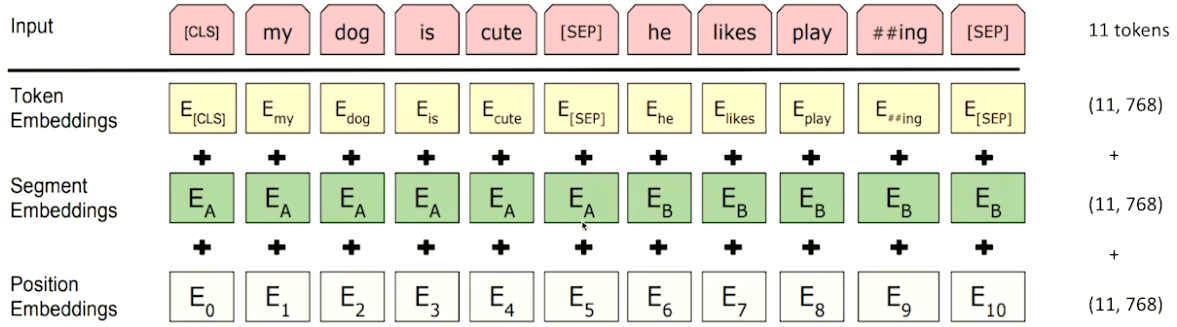

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [40]:
"""
word_embeddings == context-free word embeddings
position_embeddings == encodes word position
token_embeddings == 0 or 1. Used to lookup segment embedding
"""
model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [43]:
example_phrase = "I am Sombrero"

# return_tensors='pt' converts to PyTorch automatically
tokenizer.encode(example_phrase, return_tensors='pt')

tensor([[  101,  1045,  2572,  2061, 19908,  3217,   102]])

In [44]:
# context-less embedding of each token in the sentence
model.embeddings.word_embeddings(tokenizer.encode(example_phrase, return_tensors='pt'))

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0211,  0.0059, -0.0179,  ...,  0.0163,  0.0122,  0.0073],
         [-0.0437, -0.0150,  0.0029,  ..., -0.0282,  0.0474, -0.0448],
         ...,
         [-0.0355, -0.0371,  0.0133,  ..., -0.0315, -0.0676, -0.0568],
         [-0.0845, -0.0528,  0.0119,  ..., -0.0188,  0.0119, -0.0545],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [45]:
# note the first and last row are the same because they are the
# CLS and SEP reserved tokens. They are context-free for every input.
model.embeddings.word_embeddings(tokenizer.encode('I am Matthew', return_tensors='pt'))

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0211,  0.0059, -0.0179,  ...,  0.0163,  0.0122,  0.0073],
         [-0.0437, -0.0150,  0.0029,  ..., -0.0282,  0.0474, -0.0448],
         [-0.0120, -0.0076, -0.0507,  ..., -0.0427, -0.0845, -0.0232],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [46]:
model.embeddings.position_embeddings  # 512 embeddings; one for each position in a max 512 input sequence

Embedding(512, 768)

In [54]:
model.embeddings.position_embeddings(torch.LongTensor(range(7)))  # position embeddings in our example_phrase

tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [-5.6087e-03, -1.0445e-02, -7.2288e-03,  ...,  2.0837e-02,
          3.5402e-03,  4.7708e-03],
        [-3.0871e-03, -1.8956e-02, -1.8930e-02,  ...,  7.4045e-03,
          2.0183e-02,  3.4077e-03],
        [ 6.4257e-03, -1.7664e-02, -2.2067e-02,  ...,  6.7531e-04,
          1.1108e-02,  3.7521e-03]], grad_fn=<EmbeddingBackward0>)

In [48]:
model.embeddings.token_type_embeddings  # 2 embeddings; one for sentence A and one for B

Embedding(2, 768)

In [55]:
model.embeddings.token_type_embeddings(torch.LongTensor([0] * 7))  # all tokens have the same embedding

tensor([[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        ...,
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086]],
       grad_fn=<EmbeddingBackward0>)

In [51]:
# apply feed-forward normalization layer
model.embeddings.LayerNorm(
    model.embeddings.word_embeddings(tokenizer.encode(example_phrase, return_tensors='pt')) + \
    model.embeddings.position_embeddings(torch.LongTensor(range(7))) + \
    model.embeddings.token_type_embeddings(torch.LongTensor([0] * 7))
)

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.4024e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [-6.3496e-01,  1.9748e-01,  2.5116e-01,  ..., -4.0819e-02,
           1.3468e+00, -6.9357e-01],
         ...,
         [-8.4570e-02, -1.5594e-02,  6.8924e-01,  ...,  2.2711e-01,
          -4.2099e-01, -3.4066e-01],
         [-1.0394e+00, -5.6118e-01,  4.0267e-01,  ...,  1.0526e-01,
           9.1581e-01, -5.2493e-01],
         [-1.4815e-01, -2.9485e-01, -1.6900e-01,  ..., -5.0090e-01,
           2.5442e-01, -7.0021e-02]]], grad_fn=<NativeLayerNormBackward0>)

In [52]:
# Et Viola! The many embeddings of BERT become one embedding per token
model.embeddings(tokenizer.encode(example_phrase, return_tensors='pt'))

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.4026e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [-6.3496e-01,  1.9748e-01,  2.5116e-01,  ..., -4.0819e-02,
           1.3468e+00, -6.9357e-01],
         ...,
         [-8.4570e-02, -1.5594e-02,  6.8924e-01,  ...,  2.2711e-01,
          -4.2099e-01, -3.4066e-01],
         [-1.0394e+00, -5.6118e-01,  4.0267e-01,  ...,  1.0526e-01,
           9.1581e-01, -5.2493e-01],
         [-1.4815e-01, -2.9485e-01, -1.6900e-01,  ..., -5.0090e-01,
           2.5442e-01, -7.0021e-02]]], grad_fn=<NativeLayerNormBackward0>)

In [53]:
model.embeddings(tokenizer.encode(example_phrase, return_tensors='pt')).shape

torch.Size([1, 7, 768])

### BERT Model Visualization
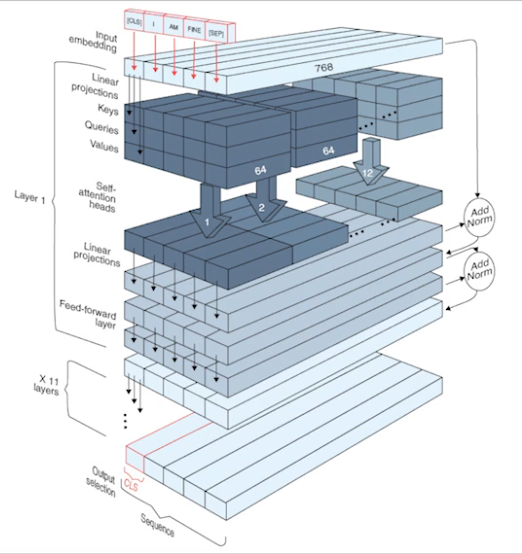